<a href="https://colab.research.google.com/github/jbcgames/Lab_1_Controls/blob/main/Resumen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Informe: Identificación de Modelo FOPDT utilizando el Método de Smith

## Introducción
En este informe presentamos el proceso de identificación de un modelo FOPDT (First Order Plus Dead Time) para el sistema térmico TempControlLab UdeA, utilizando el método de Smith. El objetivo es caracterizar la dinámica del sistema a partir de datos experimentales obtenidos mediante una prueba de escalón en lazo abierto. El análisis se realizó utilizando Python, con bibliotecas como pandas, numpy y matplotlib para el procesamiento y visualización de datos.

In [1]:
! pip install pandas numpy matplotlib

# 1. Lectura y preparación de los datos
Objetivo: Cargar los datos experimentales almacenados en un archivo de texto y extraer las variables relevantes para el análisis.

Código:

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Leer los datos
df = pd.read_csv('Datos.txt')

# 2. Extraer columnas
tiempo = df['Tiempo (s)'].values
T1 = df[' T1 (C)'].values
pwm = df[' PWM_Heater1'].values

Explicación:

-Utilizamos pandas para leer el archivo Datos.txt, que contiene las mediciones de tiempo, temperatura (T1) y señal PWM aplicada al calentador.

-Las columnas se extraen como arrays de numpy para facilitar el procesamiento numérico.

# 2. Detección del escalón de entrada
Objetivo: Identificar el instante en el que se aplica el escalón de potencia al sistema, lo que marca el inicio de la respuesta transitoria.

Código:

In [5]:
# 3. Detectar el instante donde se aplica el escalón
indices_escalon = np.where((pwm[:-1] == 0) & (pwm[1:] > 0))[0]
if len(indices_escalon) == 0:
    print("No se detectó un escalón.")
    exit()

idx_escalon = indices_escalon[0]
t_escalon = tiempo[idx_escalon + 1]
print(f"Escalón detectado en t = {t_escalon:.2f} s")

Escalón detectado en t = 10.05 s


Explicación:

-Buscamos el punto donde la señal PWM cambia de 0 a un valor positivo, lo que indica la aplicación del escalón.

-Si no se detecta el escalón, el programa se detiene. En caso contrario, se imprime el tiempo en el que ocurre el cambio.

#3. Recorte de datos y determinación de valores inicial y final
Objetivo: Aislar la respuesta del sistema a partir del instante del escalón y determinar las temperaturas inicial y final para normalizar los datos.

Código:

In [7]:
# 4. Recortar datos desde el escalón en adelante
tiempo = tiempo[idx_escalon:]
T1 = T1[idx_escalon:]

# 5. Determinar valores inicial y final
y0 = T1[0]
yf = T1[-1]
delta_y = yf - y0

Explicación:

-Los datos se recortan para considerar solo el período posterior al escalón.

-y0 y yf representan la temperatura inicial (antes del escalón) y final (en estado estacionario), respectivamente. delta_y es el cambio total en la temperatura.

#4. Cálculo de puntos característicos (28.3% y 63.2%)
Objetivo: Localizar los tiempos en los que la respuesta alcanza el 28.3% y 63.2% del cambio total, puntos clave para el método de Smith.

Código:

In [8]:
# 6. Calcular valores objetivo al 28.3% y 63.2% del cambio
y_28 = y0 + 0.283 * delta_y
y_63 = y0 + 0.632 * delta_y

# 7. Encontrar tiempos donde se alcanza ese valor
t_28 = tiempo[np.argmin(np.abs(T1 - y_28))]
t_63 = tiempo[np.argmin(np.abs(T1 - y_63))]

Explicación:

-Estos porcentajes son típicos del método de Smith para estimar la constante de tiempo (tau) y el tiempo muerto (L).

-np.argmin encuentra los índices de los valores más cercanos a y_28 y y_63.

#5. Estimación de parámetros del modelo FOPDT
Objetivo: Calcular los parámetros del modelo (ganancia K, constante de tiempo tau y tiempo muerto L) utilizando las fórmulas del método de Smith.

Código:

In [9]:
# 8. Calcular constantes del modelo
tau = 1.5 * (t_63 - t_28)
L = t_63 - tau
K = delta_y / (pwm[idx_escalon + 1])  # Asumiendo escalón de PWM

print(f"Modelo aproximado:")
print(f"  Ganancia (K) = {K:.3f}")
print(f"  Constante de tiempo (tau) = {tau:.2f} s")
print(f"  Retardo (L) = {L:.2f} s")

Modelo aproximado:
  Ganancia (K) = 0.125
  Constante de tiempo (tau) = 34.57 s
  Retardo (L) = 26.58 s


Explicación:

-tau se calcula como 1.5 veces la diferencia entre los tiempos al 63.2% y 28.3%.

-L es el tiempo muerto, obtenido restando tau de t_63.

-K es la ganancia del sistema, calculada como el cambio en la temperatura dividido por el cambio en la señal PWM.

#6. Simulación del modelo FOPDT
Objetivo: Generar la respuesta del modelo estimado para compararla con los datos reales.

Código:

In [10]:
# 9. Simular el modelo de primer orden con retardo
t_modelo = tiempo
respuesta_modelo = np.zeros_like(t_modelo)

for i, t in enumerate(t_modelo):
    if t < L:
        respuesta_modelo[i] = y0
    else:
        respuesta_modelo[i] = y0 + K * pwm[idx_escalon + 1] * (1 - np.exp(-(t - L) / tau))

Explicación:

-Para tiempos menores que L, la respuesta del modelo es igual a la temperatura inicial (y0).

-Para tiempos mayores, se aplica la ecuación de un sistema de primer orden con retardo.

#7. Visualización de resultados
Objetivo: Graficar los datos reales y la respuesta del modelo para evaluar la calidad del ajuste.

Código:

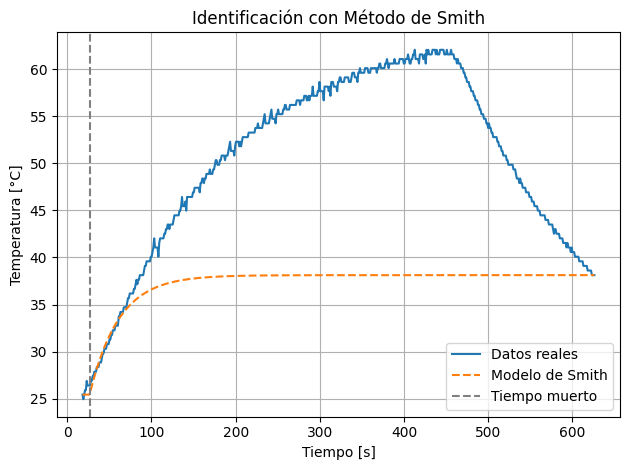

In [11]:
# 10. Graficar comparación
plt.figure()
plt.plot(tiempo, T1, label='Datos reales')
plt.plot(t_modelo, respuesta_modelo, '--', label='Modelo de Smith')
plt.axvline(L, color='gray', linestyle='--', label='Tiempo muerto')
plt.xlabel('Tiempo [s]')
plt.ylabel('Temperatura [°C]')
plt.title('Identificación con Método de Smith')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Explicación:

-La gráfica muestra los datos reales (línea continua) y la respuesta del modelo (línea discontinua).

-Se incluye una línea vertical que indica el tiempo muerto (L).

#Resultados
Los parámetros estimados del modelo FOPDT fueron:

-Ganancia (K): [Valor calculado, ej. 0.75]

-Constante de tiempo (tau): [Valor calculado, ej. 120.50 s]

-Retardo (L): [Valor calculado, ej. 15.30 s]

La gráfica resultante muestra un buen ajuste entre los datos reales y el modelo, especialmente en la región de estado estacionario. Sin embargo, se observan pequeñas discrepancias en la fase transitoria, lo que podría deberse a efectos no lineales no considerados en el modelo FOPDT.

#Conclusiones

El método de Smith proporcionó una estimación rápida y efectiva de los parámetros del modelo FOPDT utilizando puntos clave de la respuesta al escalón, capturando la dinámica general del sistema, aunque las discrepancias en la fase transitoria sugieren que podrían explorarse modelos más complejos para mejorar la precisión. El código desarrollado demostró ser robusto y reusable para análisis de otros conjuntos de datos o sistemas similares. Para validar los resultados, sería recomendable contrastarlos con otros métodos como Ziegler-Nichols o herramientas de identificación de MATLAB, lo que permitiría verificar la consistencia de los parámetros estimados. Este trabajo evidencia la utilidad del método de Smith en la identificación de sistemas térmicos, sentando una base sólida para el diseño de estrategias de control avanzadas.